In [2]:
import pandas as pd
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#### 1. Loading and preparing data 

In [3]:
# Loading LUMIERE data
lumiere_data = pd.read_excel('lumiere.xlsx')

# Clearing LUMIERE data
lumiere_data = lumiere_data[['Original title', 'Producing country', 'Production year', 'Directors']]
lumiere_data = lumiere_data.dropna(subset=['Directors'])

In [4]:
# Loading IMDb data
title_basics = pd.read_csv('title.basics.tsv', sep='\t', low_memory=False)
title_crew = pd.read_csv('title.crew.tsv', sep='\t', low_memory=False)
name_basics = pd.read_csv('name.basics.tsv', sep='\t', low_memory=False)

In [5]:
# Converting columns to a single type, cleaning data from incorrect values ​​and null values
lumiere_data['Production year'] = lumiere_data['Production year'].astype(str)
title_basics = title_basics[title_basics['startYear'].notna()]
title_basics['startYear'] = title_basics['startYear'].astype(str)

In [6]:
# Filtering IMDb data
title_basics = title_basics[title_basics['titleType'] == 'movie']

In [7]:
# Merging LUMIERE and IMDb data
merged_data = lumiere_data.merge(title_basics, left_on=['Original title', 'Production year'], 
                                 right_on=['primaryTitle', 'startYear'], how='inner')

In [8]:
# Attaching information about directors
directors_data = merged_data.merge(title_crew[['tconst', 'directors']], 
                                   left_on='tconst', right_on='tconst', how='inner')
directors_data = directors_data.assign(directors=directors_data['directors'].str.split(",")).explode('directors')
directors_data = directors_data.merge(name_basics[['nconst', 'primaryName']], 
                                      left_on='directors', right_on='nconst', how='inner')

#### 2. Determining the gender of directors

In [9]:
# Initializing the gender-guesser detector
d = gender.Detector()

In [10]:
# Function for determining gender using gender-guesser
def get_gender(name):
    first_name = name.split()[0]
    local_gender = d.get_gender(first_name)
    return local_gender

In [11]:
# Using a function to determine the gender of each director
directors_data['Gender'] = directors_data['primaryName'].apply(get_gender)

In [12]:
directors_data['Gender'].value_counts()

Gender
male             2374
female            693
unknown           232
mostly_male        69
mostly_female      30
andy               21
Name: count, dtype: int64

In [13]:
# Unifying data and removing null values
directors_data['Gender'] = directors_data['Gender'].replace({'mostly_male': 'male', 'mostly_female': 'female'})
directors_data.drop(directors_data[directors_data['Gender'].isin(['unknown', 'andy'])].index, inplace=True)

In [14]:
directors_data['Gender'].value_counts()

Gender
male      2443
female     723
Name: count, dtype: int64

In [15]:
directors_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3166 entries, 0 to 3418
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Original title     3166 non-null   object
 1   Producing country  3166 non-null   object
 2   Production year    3166 non-null   object
 3   Directors          3166 non-null   object
 4   tconst             3166 non-null   object
 5   titleType          3166 non-null   object
 6   primaryTitle       3166 non-null   object
 7   originalTitle      3166 non-null   object
 8   isAdult            3166 non-null   object
 9   startYear          3166 non-null   object
 10  endYear            3166 non-null   object
 11  runtimeMinutes     3166 non-null   object
 12  genres             3166 non-null   object
 13  directors          3166 non-null   object
 14  nconst             3166 non-null   object
 15  primaryName        3166 non-null   object
 16  Gender             3166 non-null   object
dtype

#### 3. Data Analysis and Visualization

Gender
male      77.163613
female    22.836387
Name: proportion, dtype: float64


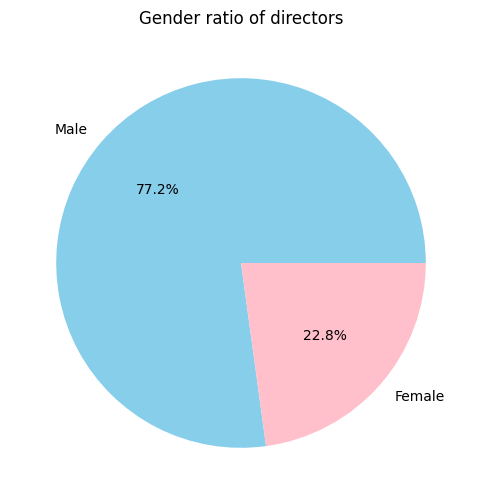

In [16]:
# Gender ratio of directors
gender_counts = directors_data['Gender'].value_counts(normalize=True) * 100
print(gender_counts)

plt.figure(figsize=(6, 6))
gender_counts.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'pink'], labels=['Male', 'Female'])
plt.title('Gender ratio of directors')
plt.ylabel('')
plt.show()

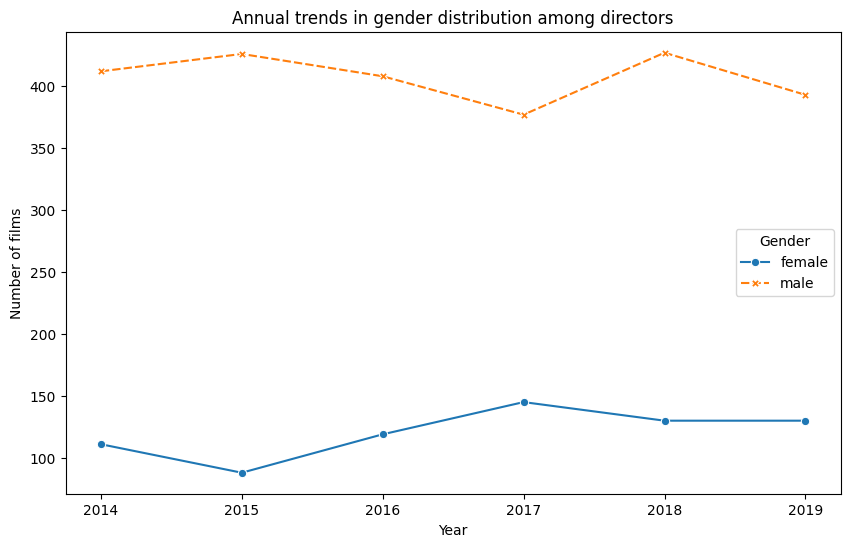

In [17]:
# Counting the number of films by year and gender
year_gender = directors_data.groupby(['Production year', 'Gender'])['titleType'].count().unstack()

plt.figure(figsize=(10, 6))
sns.lineplot(data=year_gender, markers=True)
plt.title('Annual trends in gender distribution among directors')
plt.xlabel('Year')
plt.ylabel('Number of films')
plt.legend(title='Gender')
plt.show()

In [18]:
# Function for counting genres
def count_genres(data, column='genres'):
    genre_list = data[column].dropna().str.split(',')
    flattened_genres = [genre.strip() for sublist in genre_list for genre in sublist]
    return Counter(flattened_genres)

In [19]:
# Function for combining rare genres
def group_rare_genres(genre_counts, threshold=0.01):
    total = sum(genre_counts.values())
    grouped = {}
    other_count = 0

    for genre, count in genre_counts.items():
        if count / total < threshold:
            other_count += count
        else:
            grouped[genre] = count

    if other_count > 0:
        grouped["Other"] = other_count

    return grouped

In [20]:
# Separation of data by directors' gender
female_directors = directors_data[directors_data['Gender'] == 'female']
male_directors = directors_data[directors_data['Gender'] == 'male']

In [21]:
# Genre count for women and men
female_genres_count = count_genres(female_directors)
male_genres_count = count_genres(male_directors)

In [22]:
# Application of the rare genre grouping function
female_genres_grouped = group_rare_genres(female_genres_count, threshold=0.03)
male_genres_grouped = group_rare_genres(male_genres_count, threshold=0.03)

In [23]:
# Converting results into dataframes for easy visualization
female_genres_df = pd.DataFrame.from_dict(female_genres_grouped, orient='index', columns=['Count'])
male_genres_df = pd.DataFrame.from_dict(male_genres_grouped, orient='index', columns=['Count'])

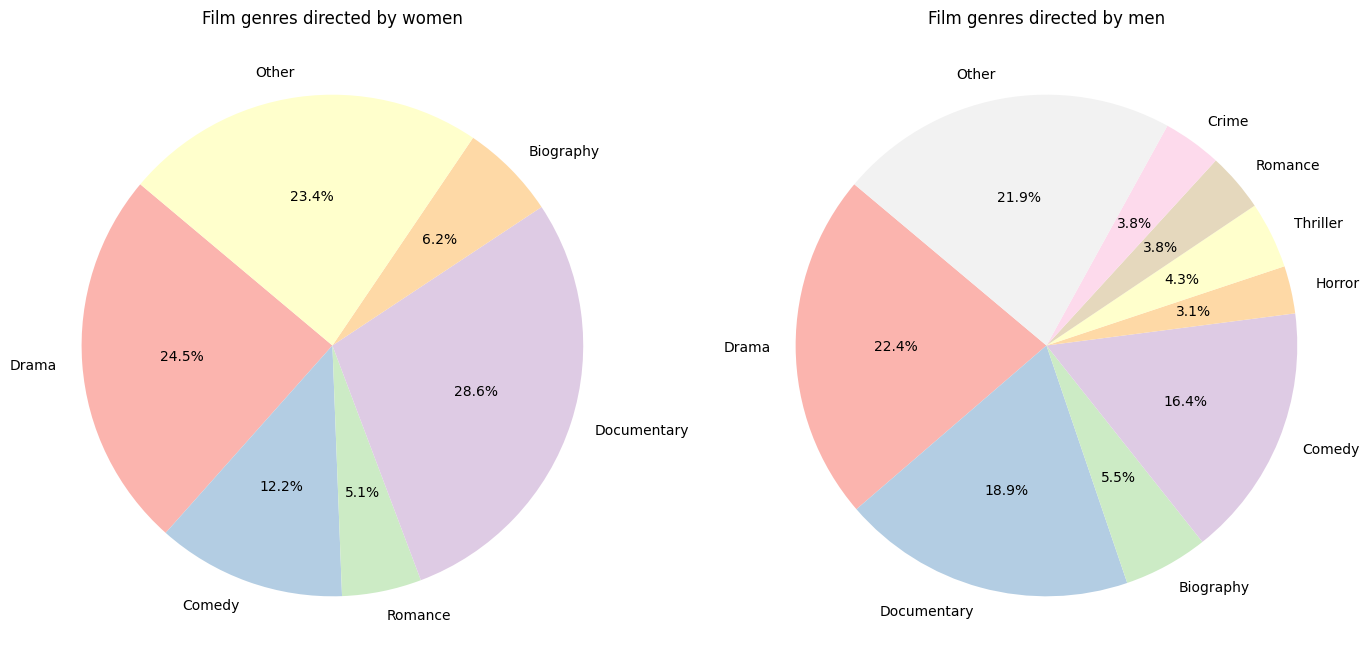

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Distribution for female directors
axes[0].pie(
    female_genres_df['Count'], 
    labels=female_genres_df.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Pastel1.colors
)
axes[0].set_title('Film genres directed by women')

# Distribution for male directors
axes[1].pie(
    male_genres_df['Count'], 
    labels=male_genres_df.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Pastel1.colors
)
axes[1].set_title('Film genres directed by men')

plt.tight_layout()
plt.show()